In [ ]:
! rm -r /content/output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix
from tensorflow.keras import layers
import tensorflow_hub as hub
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import shutil
import cv2
from tensorflow.keras.models import model_from_json
import pandas as pd

In [ ]:
img_height = 224
img_width = 224

#dataset_path_test = r'/content/output/test'
#dataset_path_train = r'/content/output/train'


dataset_path = r'/content/drive/MyDrive/SE4AI_project/arcDatasetSplitted/train/'

dataset_path_test = r'/content/drive/MyDrive/SE4AI_project/arcDatasetSplitted/test/'
dataset_path_train = r'/content/output/train'
dataset_path_val = r'/content/output/val'

In [ ]:
import splitfolders
splitfolders.ratio(dataset_path, output="output",
    seed=1337, ratio=(.7, .3, .0), group_prefix=None, move=False) # default values

ValueError: ignored

In [ ]:
def augment_data(path):
    dir_dict = {}
    for d in os.listdir(path): 
        if os.path.isdir(os.path.join(path,d)): 
            p = os.path.join(path,d)
            dir_dict[d] = len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
    nmax = max(dir_dict.values())
    for folder in os.listdir(path): 
        #if(os.path.dirname(folder) != files_names[argmax]):
        length = len([f for f in os.listdir(os.path.join(path,folder))if os.path.isfile(os.path.join(os.path.join(path,folder), f))])
        ratio = 0.0
        diff = 0
        n_instances = 0
        try:
                ratio = np.floor((nmax/length))
                diff = nmax - length
                n_instances = np.round(diff/ratio)
        except:
                ratio = 0.0
                n_instances = 0.0
        ratio = int(ratio)
        if ratio == 1: 
            files = [file for file in os.listdir(os.path.join(path,folder)) 
                 if os.path.isfile(os.path.join(os.path.join(path,folder), file))]
            j = diff
            for file in files:
                j = j - 1
                if j >= 0:
                    src = os.path.join(os.path.join(path,folder),file)
                    #print("src= ",src)
                    dst = 'copia_' + str(j) + '_' + file
                    #print("dst= ",dst)
                    shutil.copy(src,os.path.join(os.path.join(path,folder),dst))
        if ratio > 1: 
            files = [file for file in os.listdir(os.path.join(path,folder)) 
                 if os.path.isfile(os.path.join(os.path.join(path,folder), file))]
            for i in range(ratio):
                #print("ratio "+str(i))
                #print("PATH: "+os.path.join(path,folder))
                for file in files:
                        new_length = len([f for f in os.listdir(os.path.join(path,folder))if os.path.isfile(os.path.join(os.path.join(path,folder), f))])
                        if((diff - (new_length - length))>0):
                            src = os.path.join(os.path.join(path,folder),file)
                            dst = 'copia_' + str(i) + '_' + file
                            shutil.copy(src,os.path.join(os.path.join(path,folder),dst))

In [ ]:
def blur(path):
    for folder in os.listdir(path): 
        for file in os.listdir(os.path.join(path,folder)):
                img = cv2.imread(os.path.join(os.path.join(path,folder),file))
                if img is not None:
                  img = cv2.GaussianBlur(img, (5,5), 0.85)
                  src = os.path.join(os.path.join(path,folder),file)
                  os.remove(src)
                  cv2.imwrite(src,img)

In [ ]:
def hist_data(path):
    dir_dict = {}
    for d in os.listdir(path): 
        if os.path.isdir(os.path.join(path,d)): 
            p = os.path.join(path,d)
            dir_dict[d] = len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
    nmax = max(dir_dict.values())
    print(nmax)
    return dir_dict

d = hist_data(dataset_path_train)




420


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

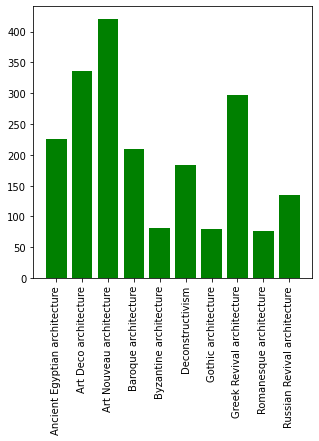

In [ ]:
plt.figure(figsize=(5,5))
plt.bar(d.keys(), d.values(), width=0.8, color='g')
plt.xticks(rotation=90)

In [ ]:
import cv2
augment_data(dataset_path_train)
#augment_data(dataset_path_test)

## Noise removal through the use of blurring
## and generalization of features inside the images. 
blur(dataset_path_train)
blur(dataset_path_val)
blur(dataset_path_test)

In [ ]:
#Creazione del dataset per il training
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_train,
    labels='inferred',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    shuffle=True,
    seed=123,
    batch_size=1)

Found 2940 files belonging to 10 classes.


In [ ]:
class_names = tuple(ds_train.class_names)
print(class_names)

('Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Byzantine architecture', 'Deconstructivism', 'Gothic architecture', 'Greek Revival architecture', 'Romanesque architecture', 'Russian Revival architecture')


In [ ]:
#Creazione del dataset per la validation
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_val,
    labels='inferred',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    shuffle=True,
    batch_size=1,
    seed=123)

Found 713 files belonging to 10 classes.


In [ ]:
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_test,
    labels='inferred',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    shuffle=True,
    seed=123,
    batch_size=1)

Found 300 files belonging to 10 classes.


In [ ]:
BATCH_SIZE = 32

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
normalization2_layer = tf.keras.layers.Normalization(mean=0, variance=1)

preprocessing_model = tf.keras.Sequential([normalization_layer, normalization2_layer])
preprocessingVal = tf.keras.Sequential([normalization_layer, normalization2_layer])

do_data_augmentation = True
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

In [ ]:
train_size = ds_train.cardinality().numpy()
ds_train = ds_train.unbatch().batch(BATCH_SIZE)
ds_train = ds_train.repeat()
ds_train = ds_train.map(lambda images, labels:
                        (preprocessing_model(images), labels))

valid_size = ds_validation.cardinality().numpy()
ds_validation = ds_validation.unbatch().batch(BATCH_SIZE)
ds_validation = ds_validation.map(lambda images, labels:
                    (
                        preprocessingVal(images),
                        labels))

test_size = ds_test.cardinality().numpy()
ds_test = ds_test.unbatch().batch(BATCH_SIZE)
ds_test = ds_test.map(lambda images, labels:
                    (
                        preprocessingVal(images),
                        labels))

In [ ]:
IMAGE_SIZE = (224, 224)
mobilenet_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(mobilenet_v2, trainable=True),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(len(class_names),
                         kernel_regularizer=tf.keras.regularizers.l2(0.005),
                         activation="softmax"
                         )
])




In [ ]:
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1792)              4363712   
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                17930     
                                                                 
Total params: 4,381,642
Trainable params: 4,333,706
Non-trainable params: 47,936
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
  metrics=['accuracy'])



In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

steps_per_epoch = train_size // BATCH_SIZE 
validation_steps = valid_size // BATCH_SIZE 
hist = model.fit(
    ds_train,
    epochs=10,
    steps_per_epoch=steps_per_epoch ,
    validation_data=ds_validation,
    validation_steps=validation_steps
    ).history


model.save('/content/drive/MyDrive/model')
model_json = model.to_json()
with open(f"/content/drive/MyDrive/Colab Notebooks/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"/content/drive/MyDrive/Colab Notebooks/model.h5")
print("Ho salvato il modello!")

Epoch 1/10
83/91 [==========================>...] - ETA: 2s - loss: 1.2847 - accuracy: 0.7718

KeyboardInterrupt: ignored

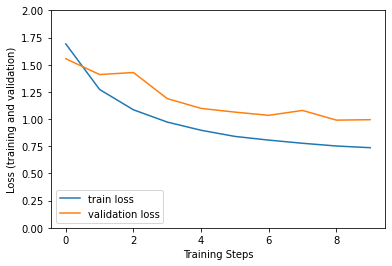

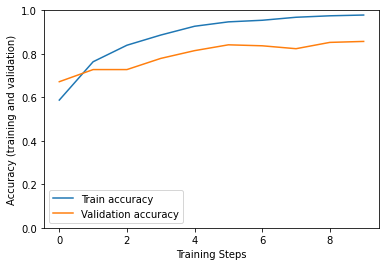

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])


plt.plot(hist["loss"], label="train loss")
plt.plot(hist["val_loss"], label="validation loss")
plt.legend(loc="lower left")

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], label="Train accuracy")
plt.plot(hist["val_accuracy"], label="Validation accuracy")
plt.legend(loc="lower left")

In [ ]:
model.evaluate(ds_test)

8/8 [==============================] - 2s 191ms/step - loss: 1.1209 - accuracy: 0.8182


[1.1208930015563965, 0.8181818127632141]

In [ ]:

predictions_test = model.predict(ds_test)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        26
         1.0       0.89      0.68      0.77        37
         2.0       0.69      0.89      0.78        45
         3.0       0.90      0.72      0.80        25
         4.0       0.67      0.67      0.67        12
         5.0       0.78      0.82      0.80        22
         6.0       0.80      1.00      0.89        12
         7.0       0.91      0.91      0.91        34
         8.0       0.64      0.75      0.69        12
         9.0       0.92      0.65      0.76        17

    accuracy                           0.82       242
   macro avg       0.82      0.81      0.81       242
weighted avg       0.83      0.82      0.82       242



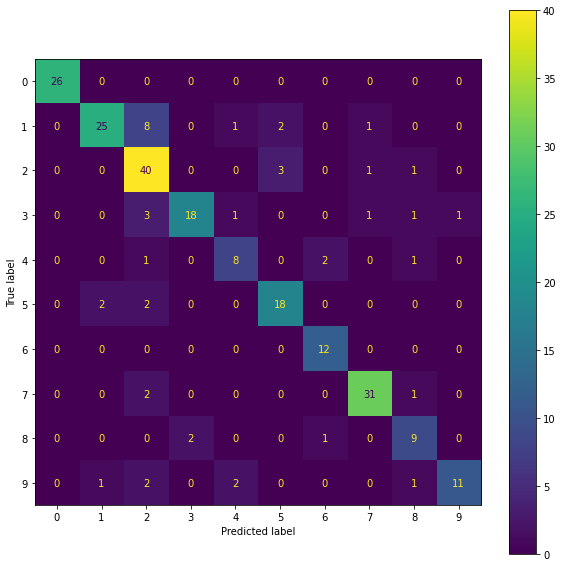

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
predictions_ = np.array([])
labels_ =  np.array([])
for x, y in ds_test:
  predictions_ = np.concatenate([predictions_, np.argmax(model.predict(x),axis=-1)])
  labels_ = np.concatenate([labels_, np.argmax(y.numpy(), axis=-1)])


Co = confusion_matrix(labels_,predictions_,labels=range(10))
cm = confusion_matrix(np.arange(10), np.arange(10))
cmp = ConfusionMatrixDisplay(Co, display_labels=np.arange(10))
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)
print(classification_report(labels_,predictions_, zero_division=0))
#print("('Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Byzantine architecture', 'Deconstructivism', 'Gothic architecture', 'Greek Revival architecture', 'Romanesque architecture', 'Russian Revival architecture')")


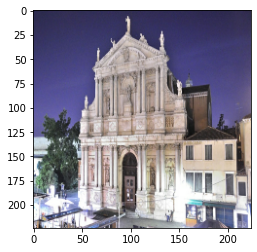

(224, 224, 3)
[[0.01113488 0.0148867  0.06524449 0.83538353 0.00132037 0.00314617
  0.01383912 0.00310918 0.00464359 0.04729194]]
True label: Baroque architecture
Predicted label: Baroque architecture


In [ ]:
x, y = next(iter(ds_test))
imag = x[15, :, :, :]
true_index = np.argmax(y[15])
plt.imshow(imag)
plt.show()
print(imag.shape)
# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(imag, axis=0))
predicted_index = np.argmax(prediction_scores)
print(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [ ]:
def prepare_image(file):
    img = image.load_img(file, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

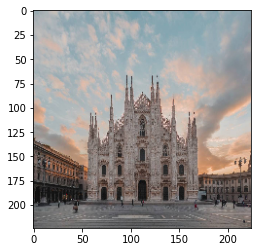

[[0.3014356  0.05268256 0.0837602  0.0645508  0.15998247 0.09807222
  0.08049576 0.07732017 0.0237361  0.05796415]]
Predicted label: Ancient Egyptian architecture
('Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Byzantine architecture', 'Deconstructivism', 'Gothic architecture', 'Greek Revival architecture', 'Romanesque architecture', 'Russian Revival architecture')


In [ ]:
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils

single_image_path = '/content/drive/MyDrive/SE4AI_project/duomo-giorno.jpg'
img = cv2.imread(single_image_path, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


preprocessed_image = prepare_image(single_image_path)
predictions = model.predict(preprocessed_image)
label = np.argmax(predictions)
print(predictions)
print("Predicted label: " + class_names[label])
print(class_names[:])

In [ ]:

model_loaded = tf.keras.Sequential()
# load json and create model
json_file = open('/content/drive/MyDrive/Colab Notebooks/model.json', 'r')
model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(model_json, custom_objects={'KerasLayer': hub.KerasLayer})
# load weights into new model
model_loaded.load_weights("/content/drive/MyDrive/Colab Notebooks/model.h5")
print("Loaded model from disk")


model_loaded.summary()

Loaded model from disk
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1792)              4363712   
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 10)                17930     
                                                                 
Total params: 4,381,642
Trainable params: 4,333,706
Non-trainable params: 47,936
_________________________________________________________________
